In [1]:
# core python
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tqdm import trange
import scipy.ndimage as nd
import collections

# astropy
import astropy.io.fits as pyfits
import astropy.io.ascii as asc
import pysynphot as S

# Grizli
import grizli
import drizzlepac
import grizli.utils as utils
import astropy.units as u
from grizli.utils import GRISM_COLORS, GRISM_MAJOR, GRISM_LIMITS, DEFAULT_LINE_LIST

# requiem2d 
os.chdir('../')
from model import Photometry, ResolvedModel 



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


In [2]:
# Process photometry
global_photometry = {'F160W': {'flam': 5.251e-18, 'eflam': 7.483e-20},
 'F390W': {'flam': 6.645e-19, 'eflam': 4.107e-19},
 'F814W': {'flam': 1.155e-18, 'eflam': 2.647e-19},
 'F105W': {'flam': 1.679e-18, 'eflam': 1.093e-19},
 'F110W': {'flam': 2.447e-18, 'eflam': 9.973e-20},
 'F125W': {'flam': 2.925e-18, 'eflam': 7.842e-20},
 'F140W': {'flam': 4.181e-18, 'eflam': 7.458e-20},
 'IRAC1': {'flam': 2.208e-18, 'eflam': 1.454e-19},
 'IRAC2': {'flam': 1.574e-18, 'eflam': 7.691e-20},
 'F606W': {'flam': 9.863e-19, 'eflam': 1.729e-19}}

bands = list(global_photometry.keys())

# Add the bandpass object to the global photometry dictionary
for band in bands :
    try:
        bp=S.ObsBandpass('wfc3,ir,{0}'.format(band))
    except:
        try:
            bp=S.ObsBandpass('wfc3,uvis1,{0}'.format(band))
        except:
            bp=S.FileBandpass('./examples/images/{0}.dat'.format(band))

    global_photometry[band]['pysyn']=bp


In [3]:
# Read and process grism files
files = glob.glob('./examples/images/*_flt.fits')
info = grizli.utils.get_flt_info(files)

ok_grism = (info['FILTER'] == 'G141')
all_grism_files = list(np.asarray(files)[ok_grism])

In [4]:
RA = 230.72328750
DEC= 25.59685833

res_model = ResolvedModel(2.4503, all_grism_files, 96, RA, DEC, global_photometry, ['IRAC1', 'IRAC2'], [],
                [], './examples/images/mrg-s1522-matched-',
                region_file='./examples/images/bins.reg',
                sci_ext=0, aper_correct_file='./examples/images/mrg-s1522-noise-phot.dat',
                remove_grism_contam=False, MW_EBV=0.0, fcontam=0, clean_im=True, 
                extra_mask = './examples/images/matched-extra-mask.fits')


#####################
#####################
#####################
Aperture correction for resolved bins = 1.23
Load ./examples/images/idxu7bdrq.01.GrismFLT.fits!
Files loaded - 0.36 sec.
Load file ./examples/images/mrg-s1522-matched-res_model_10001.stack.fits
  G141,235.0
Load file ./examples/images/mrg-s1522-matched-res_model_10002.stack.fits
  G141,235.0
Load file ./examples/images/mrg-s1522-matched-res_model_10003.stack.fits
  G141,235.0


In [5]:
# Check the resolved photometry
res_model.ref_phot_dict

{'F160W': {'global': {'flam': 5.251e-18, 'eflam': 7.483e-20},
  'pysyn': <pysynphot.obsbandpass.ObsModeBandpass at 0x7f93cb4062b0>,
  'bin_1': {'flam': 2.8222210281938287e-18,
   'eflam': 2.1966007704851007e-20,
   'Npix': 113},
  'photflam': 1.9275602e-20,
  'bin_2': {'flam': 1.2046580958069916e-18,
   'eflam': 4.433147787101881e-20,
   'Npix': 262},
  'bin_3': {'flam': 1.2241208759991795e-18,
   'eflam': 4.783678841823861e-20,
   'Npix': 287}},
 'F390W': {'global': {'flam': 6.645e-19, 'eflam': 4.107e-19},
  'pysyn': <pysynphot.obsbandpass.ObsModeBandpass at 0x7f93cb487c18>,
  'bin_1': {'flam': 1.1530396783202392e-19,
   'eflam': 1.3119751215851285e-19,
   'Npix': 113},
  'photflam': 4.91991e-19,
  'bin_2': {'flam': 6.938600941317699e-20,
   'eflam': 2.506958776351666e-19,
   'Npix': 262},
  'bin_3': {'flam': 1.57442771723981e-19,
   'eflam': 2.6892071593303926e-19,
   'Npix': 287}},
 'F814W': {'global': {'flam': 1.155e-18, 'eflam': 2.647e-19},
  'pysyn': <pysynphot.obsbandpass.ObsMod

In [6]:
# Make a dictionary for prospector priors
labels_to_keep=['dust2', 'logzsol', 'dust_index', 'duste_umin', 'duste_qpah', 'duste_gamma']
phot_prior_dict={}
weights={}

for bin_lbl in ['bin_1', 'bin_2', 'bin_3']:
    phot_prior_dict[bin_lbl]={}
    fhandle = h5py.File('./examples/images/MRG-S1522_global_mcmc.h5','r')
    theta_labels=fhandle['sampling'].attrs['theta_labels'].split('[')[1].split(']')[0].split(',')
    chains = fhandle['sampling']['chain'][:]*1.0
    for lbl in labels_to_keep:
        iloc=None
        for ith, th in enumerate(theta_labels):
            if th==' "{0}"'.format(lbl):
                iloc=ith
                break
        phot_prior_dict[bin_lbl][lbl]=chains[:,iloc]*1.0
        phot_prior_dict[bin_lbl]['dust1']=chains[:,0]*chains[:,2]*1.0
    weights[bin_lbl]=fhandle['sampling']['weights'][:]*1.0


In [7]:
# Make the joint-models
# Create them
res_model.make_joint_models(phot_prior_dict, weights,  PCA_keys=['logzsol','dust2'], 
                            PCA_nbox=[2, 2], Nbox=10, save_data=True, age_bins=20)

# Load them if they were saved before
#res_model.load_joint_models(phot_prior_dict, weights, age_bins=20)


 Analyzing bin 1, grid 1/2 x 1/2...



100%|██████████| 10/10 [01:46<00:00, 10.68s/it]



 Analyzing bin 1, grid 1/2 x 2/2...



100%|██████████| 10/10 [00:24<00:00,  2.40s/it]



 Analyzing bin 1, grid 2/2 x 1/2...



100%|██████████| 10/10 [00:23<00:00,  2.39s/it]



 Analyzing bin 1, grid 2/2 x 2/2...



100%|██████████| 10/10 [00:23<00:00,  2.40s/it]



 Analyzing bin 2, grid 1/2 x 1/2...



100%|██████████| 10/10 [00:24<00:00,  2.44s/it]



 Analyzing bin 2, grid 1/2 x 2/2...



100%|██████████| 10/10 [00:24<00:00,  2.48s/it]



 Analyzing bin 2, grid 2/2 x 1/2...



100%|██████████| 10/10 [00:24<00:00,  2.47s/it]



 Analyzing bin 2, grid 2/2 x 2/2...



100%|██████████| 10/10 [00:24<00:00,  2.47s/it]



 Analyzing bin 3, grid 1/2 x 1/2...



100%|██████████| 10/10 [00:24<00:00,  2.46s/it]



 Analyzing bin 3, grid 1/2 x 2/2...



100%|██████████| 10/10 [00:24<00:00,  2.47s/it]



 Analyzing bin 3, grid 2/2 x 1/2...



100%|██████████| 10/10 [00:24<00:00,  2.48s/it]



 Analyzing bin 3, grid 2/2 x 2/2...



100%|██████████| 10/10 [00:24<00:00,  2.48s/it]


In [8]:
# Initialize the pymc3 model
res_model.init_fitter(sfh_prior='linear_ar2', include_spectroscopy=True, regularize_old=False, tau=10,
                      low_pol=0, up_pol=4,  mixture_photometry=False, include_global=True, 
                      include_semiresolved=False, complex_dust_geometry=False)

In [9]:
# Fit it
res_model.perform_fit(tune=1000, draws=1000, save_trace=True, target_accept=0.99)

# Load the existing fit if it was saved
#res_model.load_fit()

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 48100
Interrupted at 48,099 [24%]: Average Loss = 3.3785e+05
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [pw, px, bg_scale, contam_scale, dir_a, alpha, sfr0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 837 seconds.
The number of effective samples is smaller than 25% for some parameters.


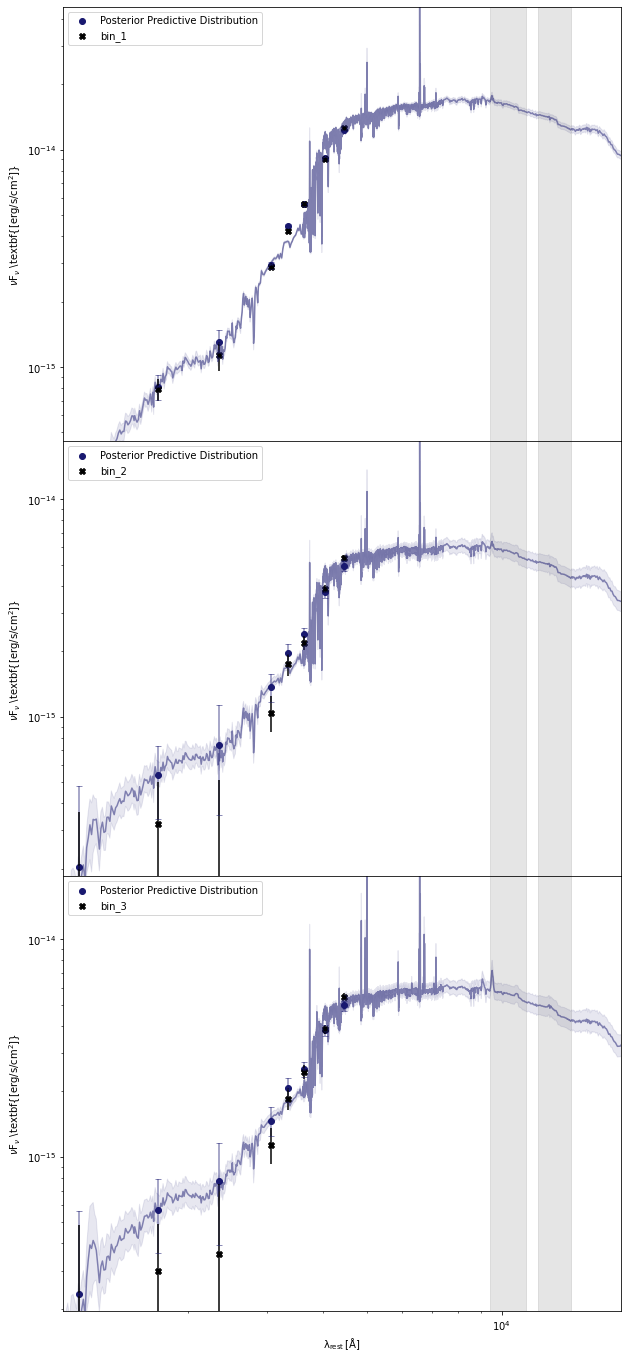

In [10]:
# Plot photometry
global_bands=['IRAC1', 'IRAC2']
pivot_wave=[]
for band in list(res_model.ref_phot_dict.keys()):
    if band in global_bands:
        continue
    pivot_wave.append(res_model.ref_phot_dict[band]['pysyn'].pivot())
pivot_wave=np.asarray(pivot_wave)

PX=res_model.trace_values['x']*1.0 # Posterior of weights, x
PW = res_model.trace_values['pw'] * 1.0 # Posterior of overall flux normalization coefficients
PWHT = res_model.trace_values['w']*1.0 # The weight determining the posteriors of nuisance parameters such as dust

phot_ppc=res_model.ppc['Phot_obs']/res_model.normal_phot # Photometric posterior predictive samples
phot_ppc=phot_ppc.reshape((phot_ppc.shape[0], res_model.P, res_model.M)) 

f, axes = plt.subplots(3, 1, sharex=True, figsize=(10,24))
f.subplots_adjust(hspace=0)

for bin_counter, id_key in enumerate(list(res_model.st.keys())):
    
    A_fsps_ = res_model.Model[id_key]['fsps']*1.0
    A_fsps = A_fsps_[:,:,:,1]*1.0

    spec_container=[]
    for ii in range(PX.shape[0]):
        if ii%10!=0:
            continue
        cf = PX[ii, : ,bin_counter] * 1.0
        spec_s = PW[ii, bin_counter]*np.tensordot(cf, A_fsps, axes=[[0], [2]])
        spec_container.append(spec_s)
    spec_container=np.asarray(spec_container).reshape((PX.shape[0]//10, (res_model.xN-1)*(res_model.yN-1), 
                                                       A_fsps.shape[-1]))
    PWHT_container = PWHT[::10,bin_counter,:]*1.0
    spec_container=np.sum(spec_container*PWHT_container[:,:,None],axis=1)
    quars_spec=np.zeros((3,spec_container.shape[-1]))
    
    for ik in range(spec_container.shape[-1]):
        quars_spec[:,ik]=np.percentile(spec_container[:,ik],q=[16,50,84])

    mock_wl=A_fsps_[0,0,0,0]/(1+res_model.z)
    xlim = (mock_wl > 500) & (mock_wl < 1.9e4)
    axes[bin_counter].plot(mock_wl[xlim], quars_spec[1][xlim]*mock_wl[xlim], alpha=0.5, color='midnightblue')
    axes[bin_counter].fill_between(mock_wl[xlim], quars_spec[0][xlim]*mock_wl[xlim],
                                quars_spec[2][xlim]*mock_wl[xlim],alpha=0.1, color='midnightblue')

    phot_sim=phot_ppc[:, :, bin_counter]*1.0
    qrts=np.percentile(phot_sim,q=[16,50,84],axis=0)
    axes[bin_counter].scatter(pivot_wave/(1 + res_model.z), qrts[1]*pivot_wave/(1 + res_model.z),
                                    color='midnightblue', label='Posterior Predictive Distribution')
    axes[bin_counter].errorbar(pivot_wave/(1 + res_model.z), qrts[1]*pivot_wave/(1 + res_model.z),
                                    yerr=[(qrts[1]-qrts[0])*pivot_wave/(1 + res_model.z), 
                                          (qrts[2]-qrts[1])*pivot_wave/(1 + res_model.z)],
                                     fmt='.', color='midnightblue', capsize=3, alpha=0.5)

    phot_flam = []
    phot_eflam = []
    for band in list(res_model.ref_phot_dict.keys()):
        if band in global_bands:
            continue
        phot_flam.append(res_model.ref_phot_dict[band][id_key]['flam'])
        phot_eflam.append(res_model.ref_phot_dict[band][id_key]['eflam'])
    phot_flam=np.asarray(phot_flam)
    phot_eflam=np.asarray(phot_eflam)
    
    X = pivot_wave/ (1 + res_model.z)
    Y = phot_flam*(1.0)
    Yerr = phot_eflam*1.0

    axes[bin_counter].scatter(X, X*Y , color='black', label=id_key, marker='X')
    axes[bin_counter].errorbar(X, X*Y, yerr=Yerr*X, fmt='.', color='black')
    axes[bin_counter].set_xlim(1050,1.85e4)
    axes[bin_counter].set_ylim((X*Y).mean()*0.1,(X*Y).mean()*10)

    axes[bin_counter].set_ylabel('$\\nu \mathrm{F}_{\\nu}$ \\textbf{[erg/s/$\mathrm{cm}^2$]}')
    if id_key=='bin_3':
        axes[bin_counter].set_xlabel('$\mathrm{\lambda}_\mathrm{rest} \, [\mathrm{\AA}]$')
    leg=axes[bin_counter].legend()
    for lh in leg.legendHandles:
        lh.set_alpha(1.0)

    axes[bin_counter].set_xscale('log')
    axes[bin_counter].set_yscale('log')
    for band_ in global_bands:
        wl_ = res_model.global_phot_dict[band_]['pysyn'].wave
        th_ = res_model.global_phot_dict[band_]['pysyn'].throughput
        axes[bin_counter].axvspan(wl_[th_>0.8*th_.max()].min()/(res_model.z+1),
                                  wl_[th_>0.8*th_.max()].max()/(res_model.z+1), color='gray', alpha=0.2)

plt.show()

In [11]:
def st_extract_1d(st, data, bin=1):
    """extract 1d spectrum from a given array data. Extracted from Grizli"""
    binned_model = collections.OrderedDict()
    beam=st.beams[0]
    ivarf=st.ivarf*1.0
    
    for grism in st.grisms:
        num = []
        den = []
        wave_x = []
        binned_model[grism] = {}
        for ib, beam in enumerate(st.beams):
            if beam.grism == grism:
                clean = (data[ib] * 1.0).flatten()
                wx = np.dot(np.ones(beam.sh[0])[:, None], beam.wave[None, :]).flatten()[beam.fit_mask]
                sx = np.dot(np.ones(beam.sh[0])[:, None], beam.sens[None, :]).flatten()
                proff = beam.optimal_profile.flatten()
                num.append((proff * clean * ivarf[ib] * sx)[beam.fit_mask])
                den.append((proff ** 2 * ivarf[ib] * sx ** 2)[beam.fit_mask])
                wave_x.append(wx)

        wave_x = np.hstack(wave_x)
        num = np.hstack(num)
        den = np.hstack(den)

        lim = utils.GRISM_LIMITS[grism]
        wave_bin = np.arange(lim[0] * 1.e4, lim[1] * 1.e4, lim[2] / bin)

        flux_bin = wave_bin * 0.
        var_bin = wave_bin * 0.

        for j in range(len(wave_bin)):
            ix = np.abs(wave_x - wave_bin[j]) < lim[2] / bin / 2.
            # ix = (wave_x > wave_bin[j]) & (wave_x <= wave_bin[j+1])
            if ix.sum() > 0:
                var_bin[j] = 1. / den[ix].sum()
                flux_bin[j] = num[ix].sum() * var_bin[j]

        binned_model[grism]['wave'] = wave_bin
        binned_model[grism]['flux'] = flux_bin
        binned_model[grism]['err'] = np.sqrt(var_bin)

    return binned_model


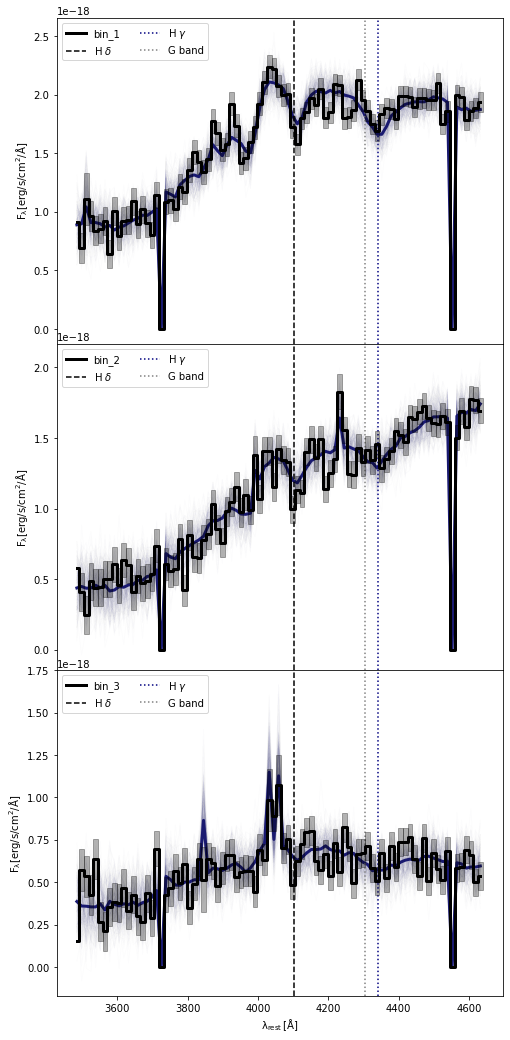

In [12]:
# Plot spectroscopy
spec_ppc=res_model.ppc['Spec_obs']*1.0 # Grism posterior predictive distribution
N_samples=spec_ppc.shape[0]

f, axes = plt.subplots(3, 1, sharex=True, figsize=(8,18))
f.subplots_adjust(hspace=0)

for bin_counter, id_key in enumerate(res_model.st.keys()):
    model_keeper = []
    
    for n in range(N_samples+1):
        if n%10!=0:
            continue
        best_modelf=res_model.st[id_key].scif*0.0
        best_modelf[res_model.fcc]=spec_ppc[n-1]*1.0
        best_modelf[~(res_model.fcc)]=res_model.st[id_key].scif[~(res_model.fcc)]*1.0
        beam = res_model.st[id_key].beams[0]
        modelff = best_modelf.reshape((res_model.st[id_key].N, beam.fit_mask.shape[0]))

        prior_fit_mask = np.zeros((res_model.st[id_key].N, beam.fit_mask.shape[0])).astype(bool)
        for ib, beam in enumerate(res_model.st[id_key].beams):
            beam.kernel = res_model.master_kernel[id_key][ib] * 1.0
            beam.kernel *= res_model.ref_phot_dict[res_model.bands[0]][id_key]['flam']
            beam._build_model()

            flat_flam_total = beam.compute_model(in_place=False, is_cgs=True)  # /self.beam.total_flux
            beam.model = flat_flam_total.reshape(beam.sh) #flat_flam.reshape(beam.sh)
            m = beam.model * 1.0
            m[(m < 0)] = 0
            beam.optimal_profile = m / m.sum(axis=0)

        binned_model = st_extract_1d(res_model.st[id_key], 
                                     (best_modelf).reshape((res_model.st[id_key].N, beam.sh[0], beam.sh[1])))
        model = np.asarray(binned_model['G141']['flux'])*1.0
        model = nd.gaussian_filter(model, sigma=0.1)
        model = np.asarray(binned_model['G141']['flux'])*1.0
        wave=np.asarray(binned_model['G141']['wave'])/(1+res_model.z)

        xlim=(wave>12000/(1+res_model.z)) & (wave<16000/(1+res_model.z))
        model_keeper.append(model)
        
        if n==N_samples:
            binned_data = st_extract_1d(res_model.st[id_key], 
                            (res_model.st[id_key].scif).reshape((res_model.st[id_key].N, beam.sh[0], beam.sh[1])))
            flux = np.asarray(binned_data['G141']['flux'])*1.0
            wave=np.asarray(binned_data['G141']['wave'])/(1+res_model.z)
            error=np.asarray(binned_data['G141']['err'])
            flux = nd.gaussian_filter(flux, sigma=0.1)
            title = id_key
            axes[bin_counter].step(wave[xlim], flux[xlim], color='black', label=title, 
                                   linewidth=3.0,zorder=3, where='mid')
            for kk in np.arange(1, wave[xlim].shape[0]):
                ymax = np.ones(2) * (flux[xlim][kk] + error[xlim][kk])
                ymin = np.ones(2) * (flux[xlim][kk] - error[xlim][kk])
                dw=0.5*(wave[xlim][kk-1]-wave[xlim][kk])
                axes[bin_counter].fill_between([wave[xlim][kk-1]-dw, wave[xlim][kk]-dw],
                                                 ymin, ymax, color='black', alpha=0.3,zorder=3)

            median_ppc_spec=np.median(np.asarray(model_keeper),axis=0)

            axes[bin_counter].plot(wave[xlim], median_ppc_spec[xlim], color='midnightblue', alpha=1.0,
                                   linewidth=3.0,zorder=2)

        else:
            axes[bin_counter].plot(wave[xlim], model[xlim], color='midnightblue', alpha=0.01, linewidth=1.0,zorder=1)


    axes[bin_counter].set_ylabel('$\mathrm{F}_{\mathrm{\lambda}}$[erg/s/$\mathrm{cm}^2$/$\mathrm{\AA}$]')
    axes[bin_counter].axvline(x=.410289 * (1e4), color='black', linestyle='dashed', label='H $\\delta$')
    axes[bin_counter].axvline(x=.434168 * (1e4), color='navy', linestyle='dotted', label='H $\gamma$')
    axes[bin_counter].legend(loc='lower right')
    axes[bin_counter].axvline(x= .430561* (1e4), color='gray', linestyle='dotted', label='G band')
    
    leg=axes[bin_counter].legend(ncol=2)
    for lh in leg.legendHandles:
        lh.set_alpha(1.0)
    if bin_counter==2:
        axes[bin_counter].set_xlabel('$\mathrm{\lambda}_\mathrm{rest} \, [\mathrm{\AA}]$')
plt.show()


In [13]:
def get_t_50(mock_cumsum,perc=0.5, AGE=res_model.AGE):
    """Calculate the median age """
    mock_ages_50 = []
    for ii in range(mock_cumsum.shape[0]):
        func_=mock_cumsum[ii]*1.0
        idc1=np.argmin(np.abs(func_-perc))
        if func_[idc1]>perc:
            idc2=idc1-1
        else:
            idc2=idc1+1
        idc=[idc1,idc2]
        x1,x2=np.log10(AGE[idc]*1.0)
        y1,y2=func_[idc]*1.0
        mock_ages_50.append(x1+(((perc-y1)*(x2-x1))/(y2-y1)))
    mock_ages_50 = 10**np.asarray(mock_ages_50)
    return mock_ages_50


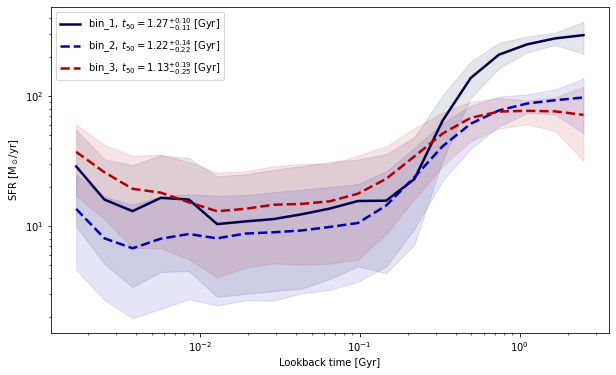

In [14]:
# Calculate and plot SFH and ages

# Calculate stellar mass
# Stellar mass teamplates from FSPS
A_mass_container=np.zeros((len(res_model.st.keys()), res_model.xN-1, res_model.yN-1, res_model.AGE.shape[0]))
for bin_counter,id_key in enumerate(res_model.st.keys()):
    A_mass_container[bin_counter]=res_model.Model[id_key]['stellar_mass']
A_mass_container = A_mass_container[None]*np.ones((PX.shape[0], res_model.M, res_model.xN-1, 
                                                   res_model.yN-1,res_model.N))

A_mass_interp=A_mass_container.reshape((PX.shape[0], len(res_model.st.keys()), 
                                        (res_model.yN-1)*(res_model.xN-1),res_model.AGE.shape[0]))
A_mass_interp=np.sum(PWHT[:,:,:,None]*A_mass_interp,axis=2) # Averaging using the weights of nuisance parameters
PM_res=PX*PW[:,None,:]*np.transpose(A_mass_interp,axes=[0,2,1]) # Posterior of stellar masses

# Calculate SFH
PSFR_res=PM_res/(res_model.AGE_width*1e9)[None,:,None] # Posterior of SFHs
qrts_res = np.percentile(PSFR_res, q=[16, 50, 84], axis=0)

# Calculate median age
PCUMSUM=np.cumsum(PM_res,axis=1)/np.sum(PM_res,axis=1,keepdims=True)
PT_res=[]
for ii in range(len(res_model.st.keys())):
    PT_res.append(get_t_50(PCUMSUM[:,:,ii]*1.0))
PT_res=np.asarray(PT_res) # Posterior of median ages

cmap=plt.cm.get_cmap('seismic')
colors=cmap([0.0,0.15,0.9])

fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
for ii in range(len(res_model.st.keys())):
    if ii==0:
        lineStyle='-'
    else:
        lineStyle='--'

    low_age, med_age, high_age=np.percentile(PT_res[ii],q=[16,50,84])
    ax.plot(res_model.AGE[1:], qrts_res[1][1:,ii], color=colors[ii], linewidth=2.5, 
            label='bin_'+str(ii+1)+', $t_{{50}}={0:1.2f}^{{+{1:1.2f}}}_{{-{2:1.2f}}}$ [Gyr]'.format(med_age, 
            high_age-med_age,med_age-low_age), linestyle=lineStyle)
    ax.fill_between(res_model.AGE[1:], qrts_res[0][1:,ii], qrts_res[2][1:,ii], color=colors[ii], alpha=0.1)

ax.set_xlabel('Lookback time [Gyr]')
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylabel('SFR [$\mathrm{M_\odot/yr}$]')
plt.legend()
plt.show()